In [5]:
# CATEGORY = "Baby_Products"
CATEGORY = "Video_Games"

# Define sequence lengths
MIN_SEQUENCE_LENGTH = 3
MAX_SEQUENCE_LENGTH = 100  # Adjust as needed

In [6]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
sys.path.append(str(PROJECT_ROOT))

# Data directory
DATA_DIR = Path(PROJECT_ROOT, "data")
DATA_DIR.mkdir(exist_ok=True)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from src.logger import setup_logger

logger = setup_logger("dataprep")

## Load and merge data

In [ ]:
# LOAD ORIGINAL METADATA
metadata_output_path = DATA_DIR / "output" / f"{CATEGORY}_items.parquet"
item_df = pl.read_parquet(metadata_output_path)
item_df = item_df[:1000] # Load only top 1000 for testing
logger.info(f"Loaded {len(item_df):,} items from {metadata_output_path}")

# LOAD AUGMENTED METADATA\
#augmented_metadata_path = DATA_DIR / "output" / f"{CATEGORY}_metadata_extracted.parquet"
#augmented_df = pl.read_parquet(augmented_metadata_path)
#logger.info(f"Loaded {len(augmented_df):,} augmented metadata records from {augmented_metadata_path}")

# LOAD CLEANED DESCRIPTIONS
cleaned_descriptions_path = DATA_DIR / "output" / f"{CATEGORY}_descriptions_clean.csv"
cleaned_descriptions_df = pl.read_csv(cleaned_descriptions_path)
cleaned_descriptions_df = cleaned_descriptions_df.unique(subset=["parent_asin"])
cleaned_descriptions_df = cleaned_descriptions_df.filter(pl.col("clean_description") != "NA")
logger.info(f"Loaded {len(cleaned_descriptions_df):,} cleaned descriptions from {cleaned_descriptions_path}")

# LOAD CLEANED TITLES
cleaned_titles_path = DATA_DIR / "output" / f"{CATEGORY}_titles_clean.csv"
cleaned_titles_df = pl.read_csv(cleaned_titles_path)
cleaned_titles_df = cleaned_titles_df.unique(subset=["parent_asin"])
cleaned_titles_df = cleaned_titles_df.filter(pl.col("clean_title") != "NA")
logger.info(f"Loaded {len(cleaned_titles_df):,} cleaned titles from {cleaned_titles_path}")

# MERGE DATAFRAMES
item_df = item_df.join(cleaned_descriptions_df, on="parent_asin", how="inner")
item_df = item_df.join(cleaned_titles_df, on="parent_asin", how="inner")
#item_df = item_df.join(augmented_df, on="parent_asin", how="left")  # Left join to keep all items
logger.info(f"Merged {len(item_df):,} items with cleaned descriptions, titles, and augmented metadata")

NameError: name 'items_df' is not defined

In [9]:
# Clean up xml tags that remain
item_df = item_df.with_columns(
    pl.col("clean_description")
    .str.replace_all(r"</?[^>]+>", " ")  # Remove all tags
    .str.replace_all(r"\s+", " ")  # Collapse multiple spaces
    .str.strip_chars()  # Trim whitespace
    .alias("clean_description"),
    pl.col("clean_title")
    .str.replace_all(r"</?[^>]+>", " ")  # Remove all tags
    .str.replace_all(r"\s+", " ")  # Collapse multiple spaces
    .str.strip_chars()  # Trim whitespace
    .alias("clean_title"),
)

assert (
    len(
        item_df.filter(pl.col("clean_description").str.contains("clean_description")).select(
            ["description_text", "clean_description"]
        )
    )
    == 0
)
assert len(item_df.filter(pl.col("clean_title").str.contains("clean_title")).select(["title", "clean_title"])) == 0

## Description Length Analysis

In [10]:
# Calculate character lengths for original and cleaned descriptions
item_df = item_df.with_columns(
    [
        pl.col("description_text").str.len_chars().cast(pl.Int64).alias("original_desc_length"),
        pl.col("clean_description").str.len_chars().cast(pl.Int64).alias("clean_desc_length"),
        pl.col("title").str.len_chars().cast(pl.Int64).alias("original_title_length"),
        pl.col("clean_title").str.len_chars().cast(pl.Int64).alias("clean_title_length"),
    ]
)

item_df = item_df.with_columns(
    [
        (pl.col("original_desc_length") - pl.col("clean_desc_length")).cast(pl.Int64).alias("desc_char_reduction"),
        ((pl.col("original_desc_length") - pl.col("clean_desc_length")) / pl.col("original_desc_length"))
        .cast(pl.Float64)
        .alias("desc_reduction_prop"),
        (pl.col("original_title_length") - pl.col("clean_title_length")).cast(pl.Int64).alias("title_char_reduction"),
        ((pl.col("original_title_length") - pl.col("clean_title_length")) / pl.col("original_title_length"))
        .cast(pl.Float64)
        .alias("title_reduction_prop"),
    ]
)

# Calculate statistics
stats = item_df.select(
    [
        pl.col("original_desc_length").mean().alias("original_desc_mean"),
        pl.col("original_desc_length").median().alias("original_desc_median"),
        pl.col("original_desc_length").std().alias("original_desc_std"),
        pl.col("clean_desc_length").mean().alias("clean_desc_mean"),
        pl.col("clean_desc_length").median().alias("clean_desc_median"),
        pl.col("clean_desc_length").std().alias("clean_desc_std"),
        (pl.col("original_desc_length") - pl.col("clean_desc_length")).mean().alias("avg_desc_reduction"),
        ((pl.col("original_desc_length") - pl.col("clean_desc_length")) / pl.col("original_desc_length") * 100)
        .mean()
        .alias("avg_desc_reduction_pct"),
    ]
)

logger.info("Description Length Statistics:")
logger.info("=" * 50)
for col in stats.columns:
    value = stats[col][0]
    if "pct" in col:
        logger.info(f"{col}: {value:.1f}%")
    else:
        logger.info(f"{col}: {value:.1f}")

# Calculate reduction statistics
total_original_chars = item_df["original_desc_length"].sum()
total_clean_chars = item_df["clean_desc_length"].sum()
total_reduction = total_original_chars - total_clean_chars
total_reduction_pct = (total_reduction / total_original_chars) * 100

logger.info("Total Character Statistics:")
logger.info("=" * 50)
logger.info(f"Total original characters: {total_original_chars:,}")
logger.info(f"Total clean characters: {total_clean_chars:,}")
logger.info(f"Total reduction: {total_reduction:,} ({total_reduction_pct:.1f}%)")

21:33:35 - Description Length Statistics:
21:33:35 - ==================================================
21:33:35 - original_desc_mean: 1114.5
21:33:35 - original_desc_median: 675.5
21:33:35 - original_desc_std: 1375.2
21:33:35 - clean_desc_mean: 607.9
21:33:35 - clean_desc_median: 585.0
21:33:35 - clean_desc_std: 282.4
21:33:35 - avg_desc_reduction: 506.5
21:33:35 - avg_desc_reduction_pct: 14.3%
21:33:35 - Total Character Statistics:
21:33:35 - ==================================================
21:33:35 - Total original characters: 1,114,468
21:33:35 - Total clean characters: 607,924
21:33:35 - Total reduction: 506,544 (45.5%)


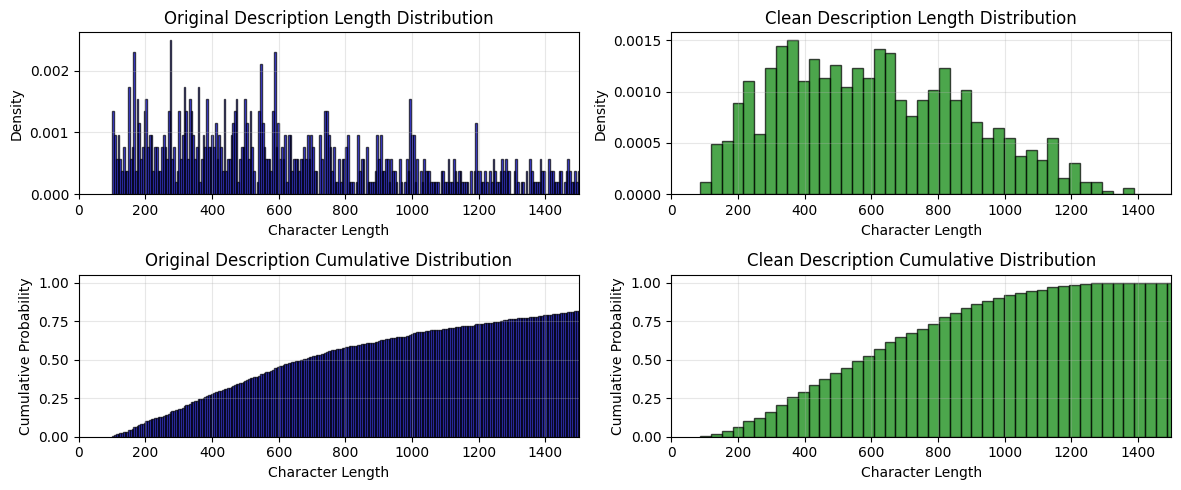

In [11]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
X_AXIS_LIMIT = 1500

# Convert to numpy arrays for plotting
original_lengths = item_df["original_desc_length"].to_numpy()
clean_lengths = item_df["clean_desc_length"].to_numpy()

# 1. Histogram with density for original descriptions
ax1 = axes[0, 0]
n1, bins1, patches1 = ax1.hist(original_lengths, bins=2000, density=True, alpha=0.7, color="blue", edgecolor="black")
ax1.set_xlabel("Character Length")
ax1.set_ylabel("Density")
ax1.set_title("Original Description Length Distribution")
ax1.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax1.grid(True, alpha=0.3)

# 2. Histogram with density for clean descriptions
ax2 = axes[0, 1]
n2, bins2, patches2 = ax2.hist(clean_lengths, bins=50, density=True, alpha=0.7, color="green", edgecolor="black")
ax2.set_xlabel("Character Length")
ax2.set_ylabel("Density")
ax2.set_title("Clean Description Length Distribution")
ax2.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution for original descriptions
ax3 = axes[1, 0]
sorted_original = np.sort(original_lengths)
cumulative_original = np.arange(1, len(sorted_original) + 1) / len(sorted_original)
ax3.hist(sorted_original, bins=2000, cumulative=True, density=True, alpha=0.7, color="blue", edgecolor="black")
ax3.set_xlabel("Character Length")
ax3.set_ylabel("Cumulative Probability")
ax3.set_title("Original Description Cumulative Distribution")
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

# 4. Cumulative distribution for clean descriptions
ax4 = axes[1, 1]
sorted_clean = np.sort(clean_lengths)
cumulative_clean = np.arange(1, len(sorted_clean) + 1) / len(sorted_clean)
ax4.hist(sorted_clean, bins=50, cumulative=True, density=True, alpha=0.7, color="green", edgecolor="black")
ax4.set_xlabel("Character Length")
ax4.set_ylabel("Cumulative Probability")
ax4.set_title("Clean Description Cumulative Distribution")
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

plt.tight_layout()
plt.show()

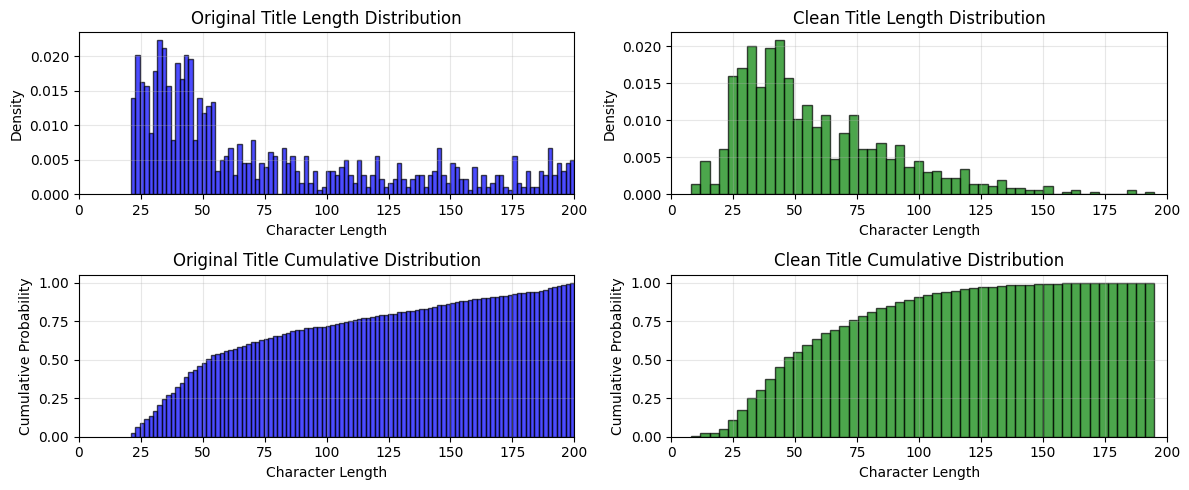

In [12]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
X_AXIS_LIMIT = 200

# Convert to numpy arrays for plotting
original_lengths = item_df["original_title_length"].to_numpy()
clean_lengths = item_df["clean_title_length"].to_numpy()

# 1. Histogram with density for original descriptions
ax1 = axes[0, 0]
n1, bins1, patches1 = ax1.hist(original_lengths, bins=100, density=True, alpha=0.7, color="blue", edgecolor="black")
ax1.set_xlabel("Character Length")
ax1.set_ylabel("Density")
ax1.set_title("Original Title Length Distribution")
ax1.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax1.grid(True, alpha=0.3)

# 2. Histogram with density for clean descriptions
ax2 = axes[0, 1]
n2, bins2, patches2 = ax2.hist(clean_lengths, bins=50, density=True, alpha=0.7, color="green", edgecolor="black")
ax2.set_xlabel("Character Length")
ax2.set_ylabel("Density")
ax2.set_title("Clean Title Length Distribution")
ax2.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution for original descriptions
ax3 = axes[1, 0]
sorted_original = np.sort(original_lengths)
cumulative_original = np.arange(1, len(sorted_original) + 1) / len(sorted_original)
ax3.hist(sorted_original, bins=100, cumulative=True, density=True, alpha=0.7, color="blue", edgecolor="black")
ax3.set_xlabel("Character Length")
ax3.set_ylabel("Cumulative Probability")
ax3.set_title("Original Title Cumulative Distribution")
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

# 4. Cumulative distribution for clean descriptions
ax4 = axes[1, 1]
sorted_clean = np.sort(clean_lengths)
cumulative_clean = np.arange(1, len(sorted_clean) + 1) / len(sorted_clean)
ax4.hist(sorted_clean, bins=50, cumulative=True, density=True, alpha=0.7, color="green", edgecolor="black")
ax4.set_xlabel("Character Length")
ax4.set_ylabel("Cumulative Probability")
ax4.set_title("Clean Title Cumulative Distribution")
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

plt.tight_layout()
plt.show()

In [13]:
# Get sample of clean descriptions with less than 200 chars, sorted by highest percentage reduction
short_clean_sample = (
    item_df.filter(pl.col("clean_desc_length") < 200)
    .sort("desc_reduction_prop", descending=True)
    .select(
        [
            "parent_asin",
            "title",
            "original_desc_length",
            "clean_desc_length",
            "desc_char_reduction",
            "desc_reduction_prop",
            "description_text",
            "clean_description",
        ]
    )
)
logger.info(f"Short clean sample: {len(short_clean_sample):,}")

pl.Config.set_fmt_str_lengths(500)
pl.Config.set_tbl_rows(50)
short_clean_sample.select(
    ["description_text", "clean_description", "original_desc_length", "clean_desc_length", "desc_reduction_prop"]
).head(5)

21:33:37 - Short clean sample: 48


description_text,clean_description,original_desc_length,clean_desc_length,desc_reduction_prop
str,str,i64,i64,f64
"""The next generation of WWE video games has arrived WWE 2K15 will usher in a new era of WWE video games and deliver the gaming experience that fans have sought for generations! System Requirements: Supported Platforms: PlayStation 3 Supported Platforms: PlayStation 3""","""WWE 2K15 ushers in a new era for WWE video games, delivering the immersive experience fans have been waiting for. This next-generation title is available on PlayStation 3.""",266,171,0.357143
"""Dishonored: The Death of the Outsider Deluxe Edition System Requirements: Supported Platforms: PlayStation 4 Supported Platforms: PlayStation 4 PlayStation account required for game activation and installation""","""Dishonored: The Death of the Outsider Deluxe Edition requires a PlayStation 4. A PlayStation account is necessary for game activation and installation.""",209,151,0.277512
"""With this Nyko Xbox Live Wireless Headset you can communicate with teammates while you play online, from anywhere in the room. Start talking to, challenging, strategizing and taunting while you play - without being bound by your wires.""","""Communicate with teammates during online gameplay using this Nyko Xbox Live Wireless Headset. Enjoy the freedom to talk, strategize, and taunt from anywhere in the room, unhindered by wires.""",235,190,0.191489
"""BLOOD BEGETS BLOOD. IMMERSE YOURSELF IN THE FIRST EIGHT LEVELS OF BLOOD, AN EXTRAORIDINARY NEW 3D FIRST - PERSON ACTION GAME.""","""Immerse yourself in the first eight levels of Blood, an extraordinary new 3D first-person action game.""",125,102,0.184
"""Product Description Xenoblade Chronicles poster (subject to limited Availability). Set Contains: Poster""","""Xenoblade Chronicles Poster. Please note this item is subject to limited availability.""",103,86,0.165049


In [14]:
pl.Config.set_fmt_str_lengths(1000)
item_df.sort("desc_char_reduction", descending=True).select(
    [
        "description_text",
        "clean_description",
        "original_desc_length",
        "clean_desc_length",
        "desc_char_reduction",
        "desc_reduction_prop",
    ]
).head(5)

description_text,clean_description,original_desc_length,clean_desc_length,desc_char_reduction,desc_reduction_prop
str,str,i64,i64,i64,f64
"""Product Description Celebrate the upcoming release of Resident Evil 6 with the complete library of Resident Evil 1-6! Included in this PlayStation 3 exclusive package is the latest installation of the blockbuster series, Resident Evil 6, along with digital copies of Resident Evil Director's Cut, Resident Evil 2, Resident Evil 3: Nemesis, Resident Evil 4 HD, and Resident Evil 5 Gold Edition redeemable on the PlayStation Network. Amazon.com Celebrate the upcoming release of Resident Evil 6 with the complete library of Resident Evil 1-6 . Included in this PlayStation 3 exclusive Resident Evil 6 Anthology package is the latest installation of the blockbuster series, Resident Evil 6 , along with digital copies of Resident Evil Directors Cut, Resident Evil 2 , Resident Evil 3: Nemesis , Resident Evil 4 HD , and Resident Evil 5 Gold Edition redeemable on the PlayStation Network. Resident Evil 6 - The Most Ambitious, Immersive Resident Evil To-date Blending action and survival horror, Resident…","""Celebrate the upcoming release of Resident Evil 6 with the complete Resident Evil 1-6 library, an exclusive PlayStation 3 package. This anthology includes the latest installment, Resident Evil 6, alongside digital versions of Resident Evil Director's Cut, Resident Evil 2, Resident Evil 3: Nemesis, Resident Evil 4 HD, and Resident Evil 5 Gold Edition. These digital titles are redeemable on the PlayStation Network. Resident Evil 6 offers the most ambitious and immersive experience to date, blending action and survival horror. Follow familiar faces Leon S. Kennedy and Chris Redfield, alongside new characters like Jake Muller, as they confront the C-virus. The narrative spans North America, Eastern Europe, and China, featuring characters such as presidential aide Derek Simmons and the enigmatic Ada Wong. With three interwoven story threads, each featuring unique protagonists and gameplay styles for solo or co-op play (offline and online), Resident Evil 6 delivers diverse perspectives. The …",10521,1086,9435,0.896778
"""With an Xbox LIVE Gold membership, take your Xbox 360 online to play Kinect and controller games with friends wherever they are. Instantly watch HD movies, TV shows and sports, and with Kinect, your voice is the remote control. Not sure what to play or watch? Quickly find new movies, songs or games with your voice. Even use your phone or tablet as a second screen to control and interact with what you’re watching. Plus, now you can explore the web on your TV with Internet Explorer for Xbox.* Entertainment is more amazing with Xbox. Take Your Xbox 360 Online To: Rent HD movies and buy TV shows, and with Kinect, your voice is the remote control. Rent HD movies and buy TV shows, and with Kinect, your voice is the remote control. Download arcade and full Xbox 360 games. Download arcade and full Xbox 360 games. Keep games fresh with new map packs, new songs and workouts Keep games fresh with new map packs, new songs and workouts * Broadband Internet, Kinect Sensor and console, games, add-ons…","""Enhance your Xbox 360 experience with Xbox LIVE Gold. Play Kinect and controller games online with friends, stream HD movies, TV shows, and sports. Use your voice to control media and easily find new content with Kinect. Your phone or tablet can act as a second screen for interactive viewing, and explore the web on your TV with Internet Explorer for Xbox. Download arcade and full Xbox 360 games, and keep your gameplay fresh with new map packs, songs, and workouts. Broadband Internet, Kinect Sensor, console, games, add-ons, and media content are sold separately. Not all Xbox LIVE features are Kinect-enabled. Visit xbox.com/live for details.""",9584,647,8937,0.932492
"""Product Description PlayStation Vita First Edition Bundle: Claim your PS Vita week before the official release date with the PlayStation Vi

In [15]:
# Get sample of clean descriptions with less than 200 chars, sorted by highest percentage reduction
short_clean_sample = (
    item_df.filter(pl.col("clean_title_length") < 200)
    .sort("title_reduction_prop", descending=True)
    .select(
        [
            "parent_asin",
            "original_title_length",
            "clean_title_length",
            "title_char_reduction",
            "title_reduction_prop",
            "title",
            "clean_title",
        ]
    )
)
logger.info(f"Short clean sample: {len(short_clean_sample):,}")

pl.Config.set_fmt_str_lengths(500)
pl.Config.set_tbl_rows(50)
short_clean_sample.select(
    ["title", "clean_title", "original_title_length", "clean_title_length", "title_reduction_prop"]
).head(5)

21:33:37 - Short clean sample: 1,000


title,clean_title,original_title_length,clean_title_length,title_reduction_prop
str,str,i64,i64,f64
"""Decoration Shell Compatible with PS5 Controller, Replacement Decorative Accessory Controller Faceplate with Guitar Pick Compatible with Playstation 5 Controller (Blue)""","""PS5 Controller Decorative Faceplate - Blue""",167,42,0.748503
"""Officially Licensed Nintendo 3DS Extendable Styluses – Pack of Three – Fits Nintendo 3DS and Nintendo DSi – Official Nintendo Licensed Product 3DS, 3DS XL, 3DS LL""","""Nintendo 3DS Extendable Styluses - 3 Pack""",162,41,0.746914
"""Dust Cover for Nintendo Switch & Switch OLED Dust Protector Custom Designed Water Proof for Nintendo Switch & Switch OLED Thick Fabric Precision Cut Easy Access Cable Port (Grey)""","""Nintendo Switch & Switch OLED Dust Cover - Grey""",178,47,0.735955
"""AC Infinity UIS to UIS Extension Cable Female to Male, 10 Foot Connection Extender Cord, Works with Controller 69, Controller 63, CLOUDRAY, CLOUDLINE LITE, IONGRID, and IONBOARD""","""AC Infinity UIS to UIS Extension Cable, 10 Foot""",177,47,0.734463
"""Playseat Evolution Sim Racing Cockpit | Comfortable Racing Simulator Cockpit | Compatible with All Steering Wheels & Pedals on The Market | Supports PC & Console | White""","""Playseat Evolution Sim Racing Cockpit - White""",169,45,0.733728


In [16]:
pl.Config.set_fmt_str_lengths(1000)
item_df.sort("title_char_reduction", descending=True).select(
    [
        "title",
        "clean_title",
        "original_title_length",
        "clean_title_length",
        "title_char_reduction",
        "title_reduction_prop",
    ]
).head(5)

title,clean_title,original_title_length,clean_title_length,title_char_reduction,title_reduction_prop
str,str,i64,i64,i64,f64
"""Dust Cover for Nintendo Switch & Switch OLED Dust Protector Custom Designed Water Proof for Nintendo Switch & Switch OLED Thick Fabric Precision Cut Easy Access Cable Port (Grey)""","""Nintendo Switch & Switch OLED Dust Cover - Grey""",178,47,131,0.735955
"""AC Infinity UIS to UIS Extension Cable Female to Male, 10 Foot Connection Extender Cord, Works with Controller 69, Controller 63, CLOUDRAY, CLOUDLINE LITE, IONGRID, and IONBOARD""","""AC Infinity UIS to UIS Extension Cable, 10 Foot""",177,47,130,0.734463
"""MightySkins Skin Compatible with Sony PS4 Controller - Monroe Currency | Protective, Durable, and Unique Vinyl Decal wrap Cover | Easy to Apply, Remove, and Change Styles | Made in The USA""","""MightySkins Skin for Sony PS4 Controller - Monroe Currency""",188,58,130,0.691489
"""MightySkins Skin Compatible with Nintendo Switch - Golden Bubbles | Protective, Durable, and Unique Vinyl Decal wrap Cover | Easy to Apply, Remove, and Change Styles | Made in The USA""","""MightySkins Skin for Nintendo Switch - Golden Bubbles""",183,53,130,0.710383
"""Carrying Case for Nintendo Switch with 2 Pack Screen Protector, 2 Pack Game Card Holder,Protective Hard Portable Travel Carry Case for 20 Game Cartridges and other Nintendo Switch Console Accessories""","""Nintendo Switch Carrying Case with Screen Protectors & Game Card Holder""",199,71,128,0.643216


In [17]:
pl.Config.restore_defaults()
item_df = item_df.rename(
    {
        "description_text": "original_description",
        "clean_description": "description_text",
        "title": "original_title",
        "clean_title": "title",
    }
)
item_df.head()

parent_asin,original_title,original_description,features_text,main_category,categories_text,store,average_rating,rating_number,price,item_context,description_text,title,original_desc_length,clean_desc_length,original_title_length,clean_title_length,desc_char_reduction,desc_reduction_prop,title_char_reduction,title_reduction_prop
str,str,str,str,str,str,str,str,i64,str,str,str,str,i64,i64,i64,i64,i64,f64,i64,f64
"""B08P38SJYF""","""Pink Xbox One Controller Skins…","""Specifications Material: Medic…","""【Safe Protect】This Pink XONES …","""All Electronics""","""Video Games > Xbox One > Acces…","""RALAN""","""4.4""",543,"""10.99""","""Product: Pink Xbox One Control…","""Protect your Xbox One, One S, …","""Pink Xbox One Controller Skin …",596,408,182,94,188,0.315436,88,0.483516
"""B00KY0QH0I""","""Tomee Charge Dock for Nintendo…","""Charge your 3DS XL with ease u…","""Charging starts instantly Uses…","""Video Games""","""Video Games > Legacy Systems >…","""Tomee""","""3.9""",93,"""""","""Product: Tomee Charge Dock for…","""The Tomee AC Charge Dock offer…","""Tomee Charging Dock for Ninten…",162,156,45,47,6,0.037037,-2,-0.044444
"""B09DFCB66S""","""PlayStation 5 Console CFI-1102…","""The PS5 console unleashes new …","""Stunning Games - Marvel at inc…","""Video Games""","""Video Games > PlayStation 5 > …","""PlayStation""","""4.9""",7332,"""449.99""","""Product: PlayStation 5 Console…","""Experience the future of gamin…","""PlayStation 5 Console CFI-1102…",285,374,31,31,-89,-0.312281,0,0.0
"""B07X8Q1MJJ""","""Durgod HK Venus RGB Mechanical…","""Compact 60% keyboard design, s…","""RGB BACKLIT - 16.8 million Col…","""Computers""","""Video Games > PC > Accessories…","""DURGOD""","""4.4""",560,"""129.99""","""Product: Durgod HK Venus RGB M…","""Experience a clean, minimalist…","""Durgod HK Venus RGB 60% Mechan…",1471,942,190,120,529,0.359619,70,0.368421
"""B077JPRCMH""","""Whiteoak PS4 Keyboard, Wireles…","""PS4 Backlit keyboard kit, so t…","""PERFECTLY COMPATIBLE - Perfect…","""All Electronics""","""Video Games > PlayStation 4 > …","""WHITEOAK""","""3.7""",435,"""""","""Product: Whiteoak PS4 Keyboard…","""Enhance your PS4 gaming experi…","""Whiteoak Wireless Mini Backlit…",769,823,145,88,-54,-0.070221,57,0.393103


In [18]:
# Coalesce categories
item_df = item_df.with_columns(
    pl.when(pl.col("categories_text") == "")
    .then(pl.col("main_category"))
    .otherwise(pl.col("categories_text"))
    .alias("categories_text")
)

assert len(item_df.filter(pl.col("categories_text") == "").select(["categories_text", "main_category"])) == 0

In [19]:
# Create item_context with augmented metadata
context_parts = [
    pl.lit("Product: "),
    pl.col("title"),
    pl.lit("\nDescription: "),
    pl.col("description_text"),
    pl.lit("\nCategory: "),
    pl.col("categories_text"),
]

# Add augmented metadata if available
if "product_type" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nProduct Type: "),
            pl.col("product_type").fill_null("Unknown"),
        ]
    )

if "platform" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nPlatform: "),
            pl.col("platform").list.join(", ").fill_null("N/A"),
        ]
    )

if "genre" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nGenre: "),
            pl.col("genre").list.join(", ").fill_null("N/A"),
        ]
    )

if "brand" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nBrand: "),
            pl.col("brand").fill_null("Unknown"),
        ]
    )

if "multiplayer" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nMultiplayer: "),
            pl.col("multiplayer").fill_null("Unknown"),
        ]
    )

if "franchise" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nFranchise: "),
            pl.col("franchise").fill_null("N/A"),
        ]
    )

item_df = item_df.with_columns(pl.concat_str(context_parts).alias("item_context"))

pl.Config.set_fmt_str_lengths(1000)
item_df.select(["item_context"]).head(5)

item_context
str
"""Product: Pink Xbox One Controller Skin Protector with 4 Pro Thumb Grips & 2 Skull Caps (Butterfly Pink) Description: Protect your Xbox One, One S, or One X controller with this high-quality, medical-grade soft silicone skin. Precisely cut for easy access to all buttons and ports, it shields your controller from shocks and scratches. The package includes six pink Pro thumb grip caps, offering both normal and extra-height options to enhance your grip and comfort during all types of gaming, including FPS and action titles. Category: Video Games > Xbox One > Accessories > Faceplates, Protectors & Skins"""
"""Product: Tomee Charging Dock for Nintendo 3DS XL (Black) Description: The Tomee AC Charge Dock offers a convenient, stationary solution for charging your 3DS XL, eliminating the need to manage cables every time you need power. Category: Video Games > Legacy Systems > Nintendo Systems > Nintendo 3DS & 2DS > Accessories > Batteries & Chargers > Chargers"""
"""Product: PlayStation 5 Console CFI-1102A Description: Experience the future of gaming with the PS5 console, designed to unlock unforeseen possibilities. Enjoy lightning-fast loading thanks to an ultra-high-speed SSD. Immerse yourself deeper with advanced features like haptic feedback, adaptive triggers, and 3D Audio. The PS5 heralds a new generation of incredible PlayStation games, offering an unparalleled gaming experience. Category: Video Games > PlayStation 5 > Consoles"""
"""Product: Durgod HK Venus RGB 60% Mechanical Gaming Keyboard | Cherry MX Blue | Doubleshot PBT Keycaps | Aluminium Chassis | White Description: Experience a clean, minimalist setup with this compact 60% mechanical keyboard. Its space-saving design frees up your desk for enhanced mouse movement and flexible keyboard placement. Enjoy lag-free gaming and typing with 100% anti-ghosting and N-key rollover, plus a disabled Windows key for uninterrupted gameplay. Access a range of media and customization functions using FN2 key combinations, including play/pause, track skipping, volume control, and mute. Switch between custom profiles on the fly. The Windows key can be locked for gaming. This keyboard features durable key switches with a lifespan of 50 million actuations. It includes a USB-C to USB-C cable (3.3ft/1m) and a USB-C to USB-A cable (5.9ft/1.8m). All keys are programmable, with independent macro and profile editors. Easily switch to arrow keys using the Tap Mode by briefly pressing …"
"""Product: Whiteoak Wireless Mini Backlit Keyboard Chatpad for PS4 Controllers with 2.4GHz Receiver Description: Enhance your PS4 gaming experience with this backlit keyboard kit, designed for easy in-game communication. Seamlessly connect this accessory to any original PS4 controller, allowing you to chat with friends, navigate the internet, and input text efficiently without interrupting your gameplay. Key Features: * **Compatibility:** Works with PS4 controllers. * **Wireless Connectivity:** Utilizes a 2.4G wireless protocol with a range of 8-10 meters (33 feet). * **Power Efficient:** Features a working current of 0.8mA and a low sleeping current of 8uA. * **Compact Design:** Weighs 70g and measures 140x70x46 mm (5.5x2.8x1.8 inches). Package Includes: * 1 x Whiteoak Wireless Backlit Keyboard for PS4 Controller (Controller not included) * 1 x 2.4GHz Micro-USB Receiver * 1 x USB Charging Cable * 1 x User Manual (English) Category: Video Games > PlayStation 4 > Accessories > Controllers"""


In [20]:
item_df.select(["original_title", "original_description", "title", "description_text"]).head(5)

original_title,original_description,title,description_text
str,str,str,str
"""Pink Xbox One Controller Skins RALAN,Silicone Controller Cover Skin Protector Compatible for Xbox Ones Controller (Pink Pro Thumb Grip x 4, Skull Cap &Cover Grip x 2)(Butterfly Pink)""","""Specifications Material: Medical Grade Soft Silicone. Usage: Protective Shell Skin for game controller Compatibility: Precisely cut for Xbox One/ S / X Controller with access precisely to all controls and ports Package Includes: Silicone Skin X 1, Pink Cap Cover grips x6 , Individuation & Comfortable Grip High quality Medical Grade silicone made controller cover for Xbox One S/X controller remote, Prevents any damage to XBOX ONE controller from shocks, scratches. Pink Pro thumb grip x 6 included in package, with normal types and extra height types for all games such as FPS, ACT and so on.""","""Pink Xbox One Controller Skin Protector with 4 Pro Thumb Grips & 2 Skull Caps (Butterfly Pink)""","""Protect your Xbox One, One S, or One X controller with this high-quality, medical-grade soft silicone skin. Precisely cut for easy access to all buttons and ports, it shields your controller from shocks and scratches. The package includes six pink Pro thumb grip caps, offering both normal and extra-height options to enhance your grip and comfort during all types of gaming, including FPS and action titles."""
"""Tomee Charge Dock for Nintendo 3DS XL (Black)""","""Charge your 3DS XL with ease using the Tomee AC Charge Dock. It provides a stationary solution without having to deal with cables every time you need to power up.""","""Tomee Charging Dock for Nintendo 3DS XL (Black)""","""The Tomee AC Charge Dock offers a convenient, stationary solution for charging your 3DS XL, eliminating the need to manage cables every time you need power."""
"""PlayStation 5 Console CFI-1102A""","""The PS5 console unleashes new gaming possibilities that you never anticipated. Experience lightning fast loading with an ultra-high speed SSD, deeper immersion with support for haptic feedback, adaptive triggers, and 3D Audio, and an all-new generation of incredible PlayStation games.""","""PlayStation 5 Console CFI-1102A""","""Experience the future of gaming with the PS5 console, designed to unlock unforeseen possibilities. Enjoy lightning-fast loading thanks to an ultra-high-speed SSD. Immerse yourself deeper with advanced features like haptic feedback, adaptive triggers, and 3D Audio. The PS5 heralds a new generation of incredible PlayStation games, offering an unparalleled gaming experience."""
"""Durgod HK Venus RGB Mechanical Gaming Keyboard | 60% Layout | USB C Wired | Doubleshot PBT Keycaps | Cherry Profile | NKRO Rollover | Windows & Mac | Aluminium Chassis| Cherry MX Blue, White""","""Compact 60% keyboard design, simple, elegant and compact size, save more space for your mouse and provides extra flexibility for your keyboard positioning. 100% anti-ghosting, N-key rollover, windows key disabled in game mode, perfect gaming and typing keyboard. This keyboard adds many functions that you can access via FN2 + combination key (eg. Shortcut to media key). Function Key: FN2+1: Play/Pause FN2+2: Stop FN2+3: Previous Track FN2+4: Next Track FN2+5: Volume Up FN2+6: Volume Down FN2+7: Mute FN2+12: Switch Customize Profile [MR Mode: The Profile could only be customized through Durgod Hera Compiler, but can we swapped on the keyboard.] FN+Left WIN: Windows Key Lock PACKAGE CONTENTS: DURGOD x HK Venus 60% mechanical keyboard User Guide Type C To Type C Cable-3.3FT/1M Type C To Type A Cable (USB Cable)5.9FT/1.8M Dust Cover Key cap Puller TECHNICAL INFORMATION . 50,000,000 actuation on key switch . Keyboard dimension: approx 300*105.8*37MM（11.8*4.1*1.35 Inch） Keyboard weight: appro…","""Durgod HK Venus RGB 60% Mechanical Gaming Keyboard | Cherry MX Blue | Doubleshot PBT Keycaps | Aluminium Chassis | White""","""Experience a clean, minimalist setup with this compact 60% mechanical keyboard. Its space-saving d

In [21]:
METADATA_COLS = [
    "parent_asin",
    "title",
    "description_text",
    "features_text",
    "main_category",
    "categories_text",
    "store",
    "average_rating",
    "rating_number",
    "price",
    # Augmented metadata columns
    "product_type",
    "platform",
    "genre",
    "hardware_type",
    "brand",
    "multiplayer",
    "franchise",
    # Context column
    "item_context",
]

# Filter to only include columns that exist in the dataframe
available_cols = [col for col in METADATA_COLS if col in item_df.columns]

item_df = item_df.select(available_cols)
logger.info(f"Selected {len(available_cols)} columns from metadata")
logger.info(f"Total items: {len(item_df):,}")
item_df.head()

21:33:37 - Selected 11 columns from metadata
21:33:37 - Total items: 1,000


parent_asin,title,description_text,features_text,main_category,categories_text,store,average_rating,rating_number,price,item_context
str,str,str,str,str,str,str,str,i64,str,str
"""B08P38SJYF""","""Pink Xbox One Controller Skin Protector with 4 Pro Thumb Grips & 2 Skull Caps (Butterfly Pink)""","""Protect your Xbox One, One S, or One X controller with this high-quality, medical-grade soft silicone skin. Precisely cut for easy access to all buttons and ports, it shields your controller from shocks and scratches. The package includes six pink Pro thumb grip caps, offering both normal and extra-height options to enhance your grip and comfort during all types of gaming, including FPS and action titles.""","""【Safe Protect】This Pink XONES Controller Cover 100% silicone material brings your controller ergonomic soft-touch ,great smooth feeling skin during the games. 【1 Skins & 6 Pink caps Grips】 There are 1x Xbox ones controller skins ,Pink Cap Cover grips x6 included in pack, choose the type to fit you controller deponds on different games for all games such as FPS, ACT and so on. 【Easy To Install】 This Silicone Skin for XBOX ONES cover very easy to install and remove, fits Xbox ones controller perfectly, would not affect any function. 【High Experience】This Anti-slip silicone friction provides comfortable gripping, prevents slipping while u play the game , no more worries for sweaty hands. 【Best Service】 If there have some reason you're not happy with this XONES Silicone Skin Controller , we'll make it right and process a refund for you soon. Your satisfaction is not an option, it's a guarantee!""","""All Electronics""","""Video Games > Xbox One > Accessories > Faceplates, Protectors & Skins""","""RALAN""","""4.4""",543,"""10.99""","""Product: Pink Xbox One Controller Skin Protector with 4 Pro Thumb Grips & 2 Skull Caps (Butterfly Pink) Description: Protect your Xbox One, One S, or One X controller with this high-quality, medical-grade soft silicone skin. Precisely cut for easy access to all buttons and ports, it shields your controller from shocks and scratches. The package includes six pink Pro thumb grip caps, offering both normal and extra-height options to enhance your grip and comfort during all types of gaming, including FPS and action titles. Category: Video Games > Xbox One > Accessories > Faceplates, Protectors & Skins"""
"""B00KY0QH0I""","""Tomee Charging Dock for Nintendo 3DS XL (Black)""","""The Tomee AC Charge Dock offers a convenient, stationary solution for charging your 3DS XL, eliminating the need to manage cables every time you need power.""","""Charging starts instantly Uses your own AC Adapter""","""Video Games""","""Video Games > Legacy Systems > Nintendo Systems > Nintendo 3DS & 2DS > Accessories > Batteries & Chargers > Chargers""","""Tomee""","""3.9""",93,"""""","""Product: Tomee Charging Dock for Nintendo 3DS XL (Black) Description: The Tomee AC Charge Dock offers a convenient, stationary solution for charging your 3DS XL, eliminating the need to manage cables every time you need power. Category: Video Games > Legacy Systems > Nintendo Systems > Nintendo 3DS & 2DS > Accessories > Batteries & Chargers > Chargers"""
"""B09DFCB66S""","""PlayStation 5 Console CFI-1102A""","""Experience the future of gaming with the PS5 console, designed to unlock unforeseen possibilities. Enjoy lightning-fast loading thanks to an ultra-high-speed SSD. Immerse yourself deeper with advanced features like haptic feedback, adaptive triggers, and 3D Audio. The PS5 heralds a new generation of incredible PlayStation games, offering an unparalleled gaming experience.""","""Stunning Games - Marvel at incredible graphics and experience new PS5 features. Breathtaking Immersion - Discover a deeper gaming experience with support for haptic feedback, adaptive triggers, and 3D Audio technology. Lightning Speed - Harness the power of a custom CPU, GPU, and SSD with Integrated I/O that rewrite the rules of what a PlayStation console can do. Mod

In [22]:
# SAVE UPDATED METADATA
updated_metadata_output_path = DATA_DIR / "output" / f"{CATEGORY}_items_updated.parquet"
item_df.write_parquet(updated_metadata_output_path)
logger.info(f"Saved updated metadata to {updated_metadata_output_path}")

21:33:37 - Saved updated metadata to /Users/bytedance/Documents/code/semantic-ids-llm/data/output/Video_Games_items_updated.parquet


## Update sequences

In [23]:
# Load the gzipped CSV file
df = pl.read_csv(f"../data/{CATEGORY}.train.csv.gz")

# Display basic information about the dataset
logger.info(f"Dataset shape: {df.shape}")
logger.info(f"Columns: {df.columns}")

df.head()

21:33:38 - Dataset shape: (736827, 5)
21:33:38 - Columns: ['user_id', 'parent_asin', 'rating', 'timestamp', 'history']


user_id,parent_asin,rating,timestamp,history
str,str,f64,i64,str
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B08R5B7YS4""",1.0,1611459666223,null
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B0863MT183""",4.0,1613701986538,"""B08R5B7YS4"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B08P8P7686""",5.0,1613702112995,"""B08R5B7YS4 B0863MT183"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B0B7LV3DN2""",4.0,1617641445475,"""B08R5B7YS4 B0863MT183 B08P8P7686"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B09WMQ6DXG""",5.0,1620231368468,"""B08R5B7YS4 B0863MT183 B08P8P7686 B0B7LV3DN2"""


In [24]:
# Deduplicate by user_id, keeping the row with the longest history
# First, calculate the length of each history
df = df.with_columns(
    pl.when(pl.col("history").is_null())
    .then(0)
    .otherwise(pl.col("history").str.count_matches(r"\S+"))
    .alias("history_length")
)

logger.info(f"Original dataset num rows: {df.shape[0]:,}")

# Sort by user_id and history_length (descending), then keep first row per user
df = df.sort(["user_id", "history_length"], descending=[False, True]).group_by("user_id").first().drop("history_length")

logger.info(f"Deduplicated dataset num rows: {df.shape[0]:,}")
logger.info(f"Number of unique users: {df.n_unique('user_id'):,}")

21:33:38 - Original dataset num rows: 736,827
21:33:38 - Deduplicated dataset num rows: 91,562
21:33:38 - Number of unique users: 91,562


In [25]:
# Create sequences column by appending parent_asin to history as a list
df = df.with_columns(pl.col("history").str.split(" ").list.concat([pl.col("parent_asin")]).alias("sequence"))
valid_items = set(item_df["parent_asin"].to_list())

df.head()

user_id,parent_asin,rating,timestamp,history,sequence
str,str,f64,i64,str,list[str]
"""AHEG4ZLBTHUGFFO445YRV46GSRCQ""","""B073K6WMJ9""",5.0,1579281872696,"""B00B08REVY B000N5Z2L4 B00TY9KYKE B00CMQTUSS B00KIWEMIG B00KVQYJR8 B002I0J8RQ B0050SYYTK B002I0HCNI B0154OZU4M B01MPZ8QL4 B01GKFPFZS B00Z9TLVK0 B07CGLJ2RF B07DFNKHFG B07BNKWG2D B07D13QGXM B01IFE2OFG B087NN2K41 B087SHFL9B B01N3ASPNV B07JFG5KFQ B071J42387 B087NM8BB6 B087NMYQYG""","[""B00B08REVY"", ""B000N5Z2L4"", … ""B073K6WMJ9""]"
"""AG7J2UJQMZKH3RFM3G47C6VEYYJQ""","""B06Y18DZ6B""",5.0,1521452222440,"""B00N3OELPU B001O5CCQK B00IRHE892 B013HSWF40 B00EUPVQ04 B00CQ35C1Q B01A0VQOCQ B071G3BRBC""","[""B00N3OELPU"", ""B001O5CCQK"", … ""B06Y18DZ6B""]"
"""AFGZXPG6GNUCIY2BMUDFEE5PNJ2A""","""B0995GXFV4""",5.0,1511970010521,"""B00WL7IK7A B00Z9TIR20 B00SVL8IWW B00PHVBM68 B015RMHO18 B00MAM0ALA""","[""B00WL7IK7A"", ""B00Z9TIR20"", … ""B0995GXFV4""]"
"""AGQPQFC2H4VHSFWQZSJC74X62FVQ""","""B00007KQC1""",4.0,1278658377000,"""B0006FQ50I B001EYUY7U B000BKSGH8 B000PQ2FE8 B001EYUQZ0 B00006LEMX B00004YRQA B00004YUWA""","[""B0006FQ50I"", ""B001EYUY7U"", … ""B00007KQC1""]"
"""AGJK2GULYWKPTSJ4SRYOUGT6WM2Q""","""B016PWS77E""",5.0,1545965232777,"""B076541PNM B017W175Y8 B01GW3H3U8 B00ZV1C600 B01AC3ZD06""","[""B076541PNM"", ""B017W175Y8"", … ""B016PWS77E""]"


In [27]:
valid_items = set(item_df["parent_asin"].to_list())


# Filter items without metadata
def filter_sequence_items(sequence_list, valid_items_set):
    if sequence_list is None:
        return None

    # Filter the list to keep only items with valid metadata
    filtered_items = [item for item in sequence_list if item in valid_items_set]

    return filtered_items if filtered_items else []


# Filter sequences where metadata is missing
df = df.with_columns(
    pl.col("sequence")
    .map_elements(lambda x: filter_sequence_items(x, valid_items), return_dtype=pl.List(pl.String))
    .alias("sequence")
)

# Filter out rows where:
# 1. The target item (parent_asin) doesn't have valid metadata
# 2. The filtered sequences is empty or null
rows_before_filtering = df.shape[0]
logger.info(f"Rows before filtering: {rows_before_filtering:,}")

df = df.filter((pl.col("sequence").is_not_null()) & (pl.col("sequence").list.len() >= MIN_SEQUENCE_LENGTH))

# Log statistics
logger.info(f"Rows after filtering: {df.shape[0]:,}")
logger.info(
    f"Rows removed: {rows_before_filtering - df.shape[0]:,} ({(rows_before_filtering - df.shape[0]) / rows_before_filtering * 100:.1f}%)"
)

21:34:30 - Rows before filtering: 91,562
21:34:30 - Rows after filtering: 526
21:34:30 - Rows removed: 91,036 (99.4%)


In [ ]:
# Truncate long sequences
# Calculate sequence lengths before truncation
df = df.with_columns(pl.col("sequence").list.len().alias("sequence_length_before"))

# Using Polars expressions for efficient truncation - take last N items
df = df.with_columns(pl.col("sequence").list.tail(MAX_SEQUENCE_LENGTH).alias("sequence"))

# Update sequence length for truncated sequences
df = df.with_columns(pl.col("sequence").list.len().alias("sequence_length"))

# Calculate truncation statistics
sequences_truncated = (df["sequence_length_before"] > MAX_SEQUENCE_LENGTH).sum()
pct_truncated = sequences_truncated / len(df) * 100

logger.info(f"Sequences truncated: {sequences_truncated:,} ({pct_truncated:.1f}%)")

# Replace the sequences column with the truncated version
df = df.drop(["sequence_length_before"])

logger.info(
    f"Sequence lengths - Min: {df['sequence_length'].min()}, Max: {df['sequence_length'].max()}, Mean: {df['sequence_length'].mean():.1f}, Median: {df['sequence_length'].median()}"
)

15:32:55 - Sequences truncated: 28 (0.0%)
15:32:55 - Sequence lengths - Min: 3, Max: 100, Mean: 6.5, Median: 5.0


In [ ]:
df.group_by("sequence_length").len().with_columns((pl.col("len") / pl.sum("len")).alias("probability")).sort(
    "sequence_length"
).with_columns(pl.col("probability").cum_sum().alias("cumulative_probability")).head(10)

sequence_length,len,probability,cumulative_probability
u32,u32,f64,f64
3,13154,0.167296,0.167296
4,17459,0.222048,0.389345
5,15689,0.199537,0.588882
6,9280,0.118026,0.706907
7,5881,0.074796,0.781703
8,4014,0.051051,0.832755
9,2817,0.035827,0.868582
10,2034,0.025869,0.894451
11,1512,0.01923,0.913681


In [ ]:
df = df.select(["user_id", "sequence", "sequence_length"])
df.head()

user_id,sequence,sequence_length
str,list[str],u32
"""AE222HFZDH6BPTYFOUWGGU63YSIQ""","[""B082R1RGZF"", ""B07SNN8GV5"", … ""B0BW17W9GM""]",5
"""AE2252DKW4XJIZP5QPFMQVJBVRTA""","[""B002ORTCAQ"", ""B0090ECASW"", … ""B07JH3LSHN""]",7
"""AE225O22SA7DLBOGOEIFL7FT5VYQ""","[""B00029QOQS"", ""B0006B7DXA"", … ""B0053BCML6""]",7
"""AE227CCN4C37WTOB3J2TZPOKLEQQ""","[""B0049U4DXM"", ""B002V8KA72"", … ""B001QCWRWK""]",9
"""AE22BPPZGGRTSYOHK2J3LCG5HGAQ""","[""B00KVP3OY8"", ""B07K3KHFSY"", … ""B0053BCML6""]",4


In [ ]:
output_path = DATA_DIR / "output" / f"{CATEGORY}_sequences_updated.parquet"
df.write_parquet(output_path)
logger.info(f"Saved filtered sequences to: {output_path} (rows = {df.shape[0]:,})")

15:32:55 - Saved filtered sequences to: /Users/eugeneyan/projects/semantic-id/data/output/Video_Games_sequences_updated.parquet (rows = 78,627)
